In [1]:
from scipy import ndimage
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter
import numpy as np

import cartopy.crs as ccrs

import os
from pathlib import Path

In [2]:
from hypercc.data.box import Box
from hypercc.data.data_set import DataSet
from hypercc.units import unit
from hypercc.filters import (taper_masked_area, gaussian_filter, sobel_filter)
from hypercc.plotting import (
    plot_mollweide, plot_orthographic_np, plot_plate_carree,
    plot_signal_histogram, earth_plot)
from hypercc.calibration import (calibrate_sobel)
from hypercc.workflow import write_netcdf_3d
from hyper_canny import cp_edge_thinning, cp_double_threshold

import netCDF4
from skimage.morphology import flood_fill

## Enter your settings here

In [3]:
#data_folder = Path("/home/bathiany/Sebastian/datamining/edges/Abrupt/hypercc/evaluation/AtmosphericRivers")
data_folder = Path("/media/bathiany/Elements/obsdata/qvi")

year=1998
months='04'
#months='01-04'
#months='05-08'
#months='09-12'


## smoothing scales
sigma_d = unit('100 km')    # space
sigma_t = unit('1 hour')    # time

### aspect ratio: all weight on space
gamma = 1e10

## date choice for illustration: 25 April 1998
timeind=26*24 + 12 #hourly data


# select data based on settings above
## No editing below this point required

In [4]:
period = str(year) + '_' + months

In [5]:
file = 'ERA5_qvi_Pacific_hourly_' + period + '.nc'
data_set = DataSet([data_folder / file ], 'qvi')

scaling_factor = gamma * unit('1 km/year')
sobel_delta_t = unit('1 year')
sobel_delta_d = sobel_delta_t * scaling_factor
sobel_weights = [sobel_delta_t, sobel_delta_d, sobel_delta_d]

## Load and inspect the data

Next we define a `box`. The box contains all information on the geometry of the data. It loads the lattitudes and longitudes of the grid points from the NetCDF file and computes quantities like resolution.

In [6]:
from datetime import date, timedelta

box = data_set.box

print("({:.6~P}, {:.6~P}, {:.6~P}) per pixel".format(*box.resolution))
for t in box.time[:3]:
    print(box.date(t), end=', ')
print(" ...")

dt = box.time[1:] - box.time[:-1]
print("time steps: max", dt.max(), "min", dt.min())

(0.00273785 year, 27.7987 km, 27.7987 km) per pixel
1998-03-08, 1998-03-08, 1998-03-08,  ...
time steps: max 1.0 min 1.0


In [7]:
data = data_set.data

In [8]:
lons = box.lon.copy()
lats = box.lat.copy()

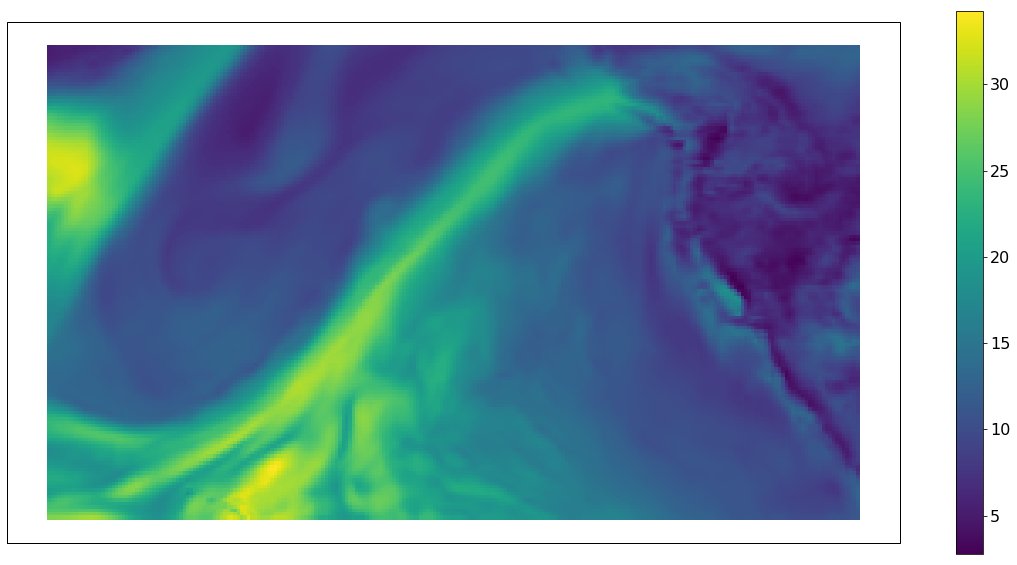

In [9]:
# a look at the event

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
pcm = ax.pcolormesh(
lons, lats, data_set.data[timeind,:,:])
cbar = fig.colorbar(pcm)
cbar.ax.tick_params(labelsize=16)
#ax.coastlines()
#fig.colorbar(pcm, labelsize=10)

In [22]:
# Smoothing
smooth_data = gaussian_filter(box, data, [sigma_t, sigma_d, sigma_d])

In [23]:
del data

### Sobel filtering
The Sobel filter has the same problem as the Gaussian filter, but the solution is easier. We just correct for the magnitude of the Sobel response by multiplying the longitudinal component by the cosine of the latitude.

In [24]:
sb = sobel_filter(box, smooth_data, weight=sobel_weights)
pixel_sb = sobel_filter(box, smooth_data, physical=False)

In [25]:
del smooth_data

### Determine hysteresis settings

In [26]:
signal = 1/sb[3]

In [27]:
### set thresholds

perc_upper=95
perc_lower=90

upper_threshold=np.percentile(signal, perc_upper)
lower_threshold=np.percentile(signal, perc_lower)


In [28]:
del signal

In [29]:
# use directions of pixel based sobel transform and magnitudes from calibrated physical sobel.
dat = pixel_sb.transpose([3,2,1,0]).astype('float32')
del pixel_sb
dat[:,:,:,3] = sb[3].transpose([2,1,0])

mask = cp_edge_thinning(dat)
#thinned = mask.transpose([2, 1, 0])
dat = sb.transpose([3,2,1,0]).copy().astype('float32')

In [30]:
edges = cp_double_threshold(data=dat, mask=mask, a=1/upper_threshold, b=1/lower_threshold)
m = edges.transpose([2, 1, 0])

In [31]:
del mask

In [32]:
#plot_signal_histogram(box, signal, lower_threshold, upper_threshold);

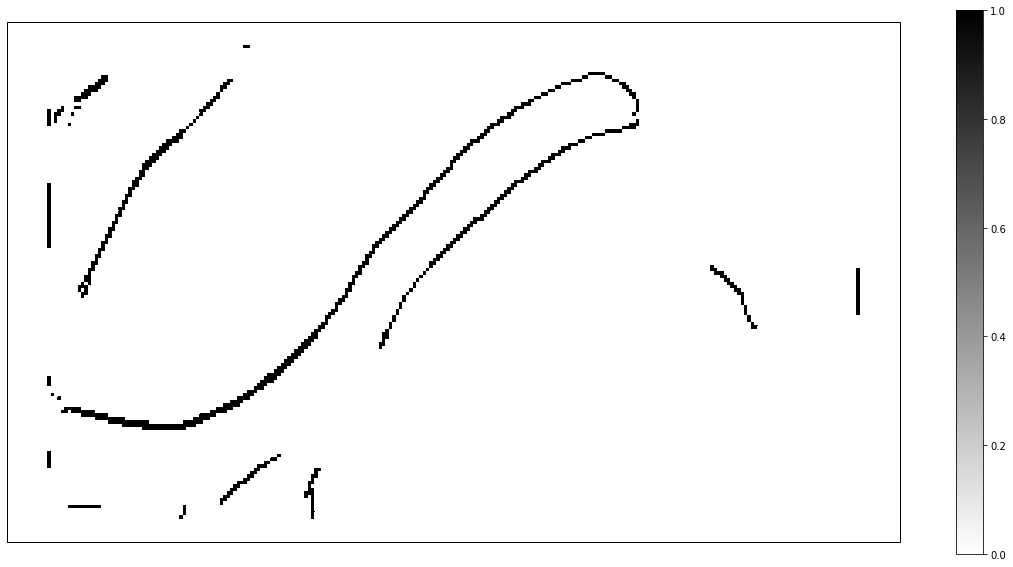

In [33]:
cmap_rev = cm.get_cmap('gray_r')
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
pcm = ax.pcolormesh(
lons, lats, m[timeind], cmap=cmap_rev)
ax.coastlines()
fig.colorbar(pcm)

In [34]:
## remove spurious boundary effects (resulting from imposed periodicity)
m[:,0:1,:]=0
m[:,:,0:1]=0
#m[:,np.size(m, axis=1)-1,:]=0
#m[:,:,np.size(m, axis=2)-1]=0

m[:,-2:-1,:]=0
m[:,:,-2:-1]=0


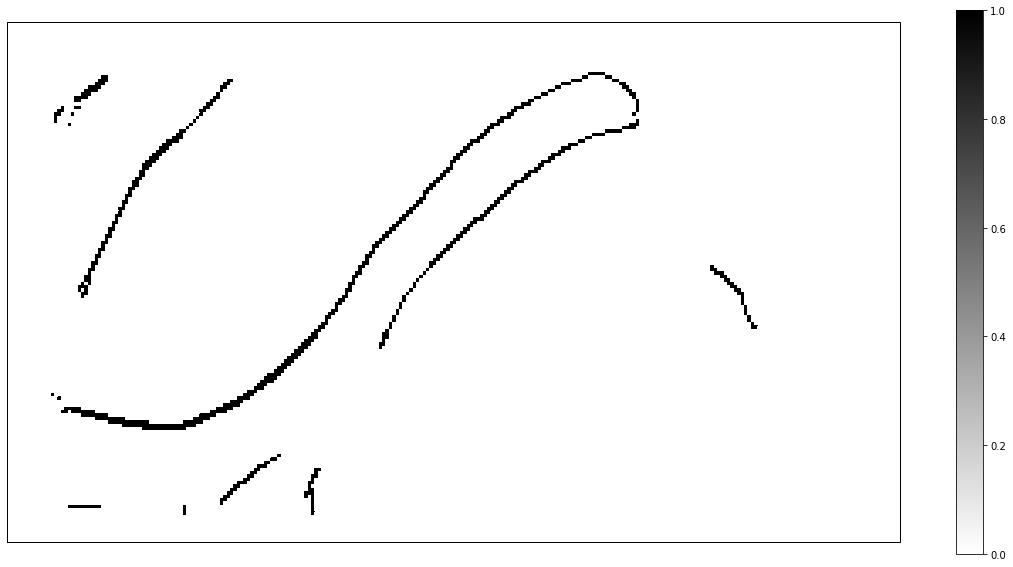

In [35]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
pcm = ax.pcolormesh(
lons, lats, m[timeind], cmap=cmap_rev)
ax.coastlines()
fig.colorbar(pcm)

In [36]:
# load lsm

lsmfile = netCDF4.Dataset(data_folder / "ERA5_lsm_Pacific.nc", "r", format="NETCDF4")
lsm = lsmfile.variables['lsm'][:,:,:]


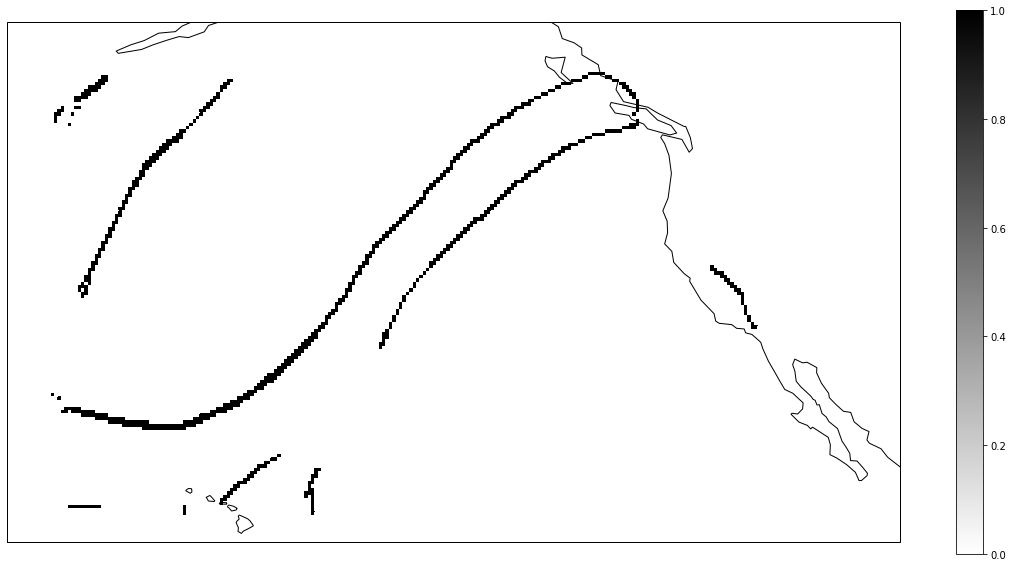

In [37]:
# show edges with coastlines

#fig = plt.figure(figsize=(20, 10))
#ax = fig.add_subplot(111, projection=ccrs.Mercator())
#pcm = ax.pcolormesh(
#lons, lats, m[timeind,:,:])
#ax.coastlines()
#fig.colorbar(pcm)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
pcm = ax.pcolormesh(
lons, lats, m[timeind,:,:], cmap=cmap_rev)
ax.coastlines()
#plt.show()
fig.colorbar(pcm)

In [ ]:
### the next lines cut parts of land according to criteria in Dettinger et al., 2011 (Table 1)

## all cells with little bit of land become 1
lsm[lsm>0]=1

## remove Western parts (islands)
lsm[:,:,0:70]=0

## remove Southern parts of coast (Mexico)
lsm[:,99:141:]=0


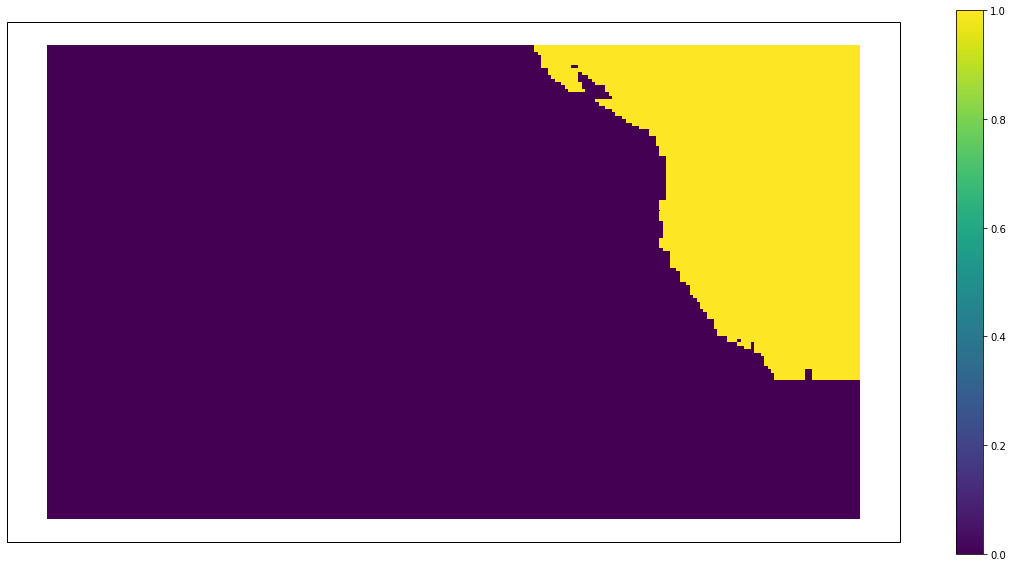

In [85]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
pcm = ax.pcolormesh(
lons, lats, lsm[0,:,:])
ax.coastlines()
fig.colorbar(pcm)

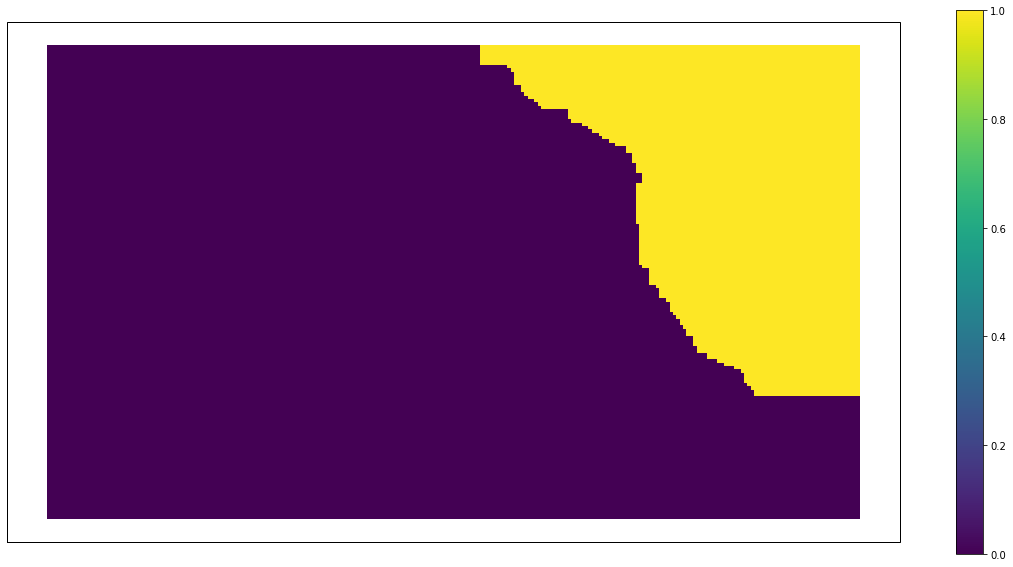

In [86]:
## shift coast to the West 
#(in order to not miss atmospheric rivers that are a few pixels away; smoothing can destroy such links)

## use gaussian filter to do that:
sigma_lon_lsm = unit('33 km')    # space
sigma_lat_lsm = unit('33 km')    # space
sigma_t_lsm = unit('0 hour')    # time

lsm = gaussian_filter(box, lsm, [sigma_t_lsm, sigma_lat_lsm, sigma_lon_lsm])

lsm[lsm>0]=1

# remove Western parts (islands)
lsm[:,:,0:70]=0

### remove most Eastern column to avoid circular connectivity between East and West:
#lsm[:,:,239:240]=0

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
pcm = ax.pcolormesh(
lons, lats, lsm[0,:,:])
ax.coastlines()
fig.colorbar(pcm)

In [87]:
## add to mask of detected edges
mask_sum=m+lsm

mask_sum[mask_sum>1]=1

mask_sum=mask_sum.astype(int)

In [88]:
del m

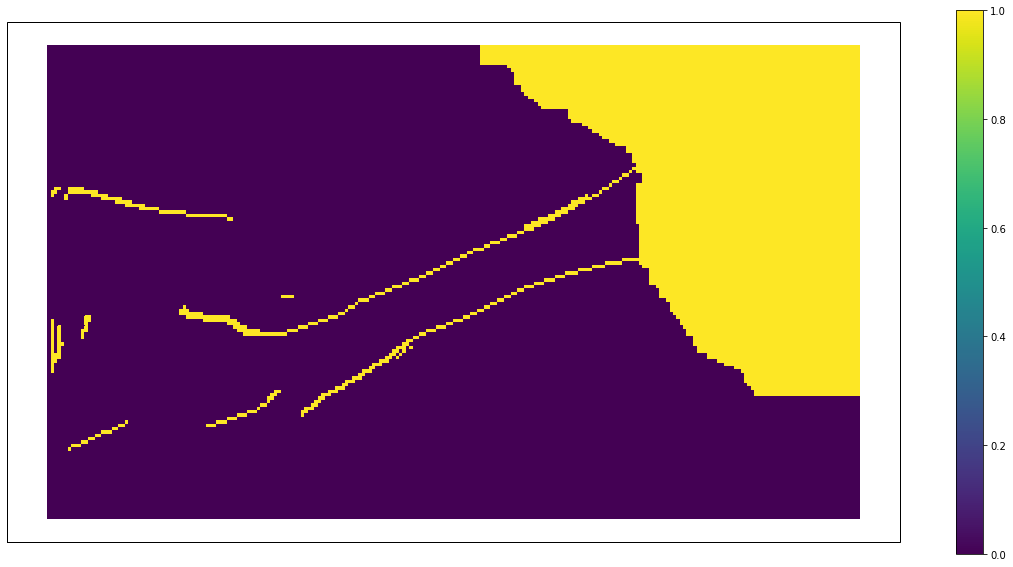

In [89]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
pcm = ax.pcolormesh(
lons, lats, mask_sum[timeind,:,:])
ax.coastlines()
fig.colorbar(pcm)

In [90]:
## floodfill

In [91]:
mask_floodfilled=mask_sum*0
for timeind_flood in range(0,np.size(mask_floodfilled, axis=0)):
    mask_floodfilled[timeind_flood] = flood_fill(mask_sum[timeind_flood,:,:], (0,239), 2)

In [92]:
del mask_sum

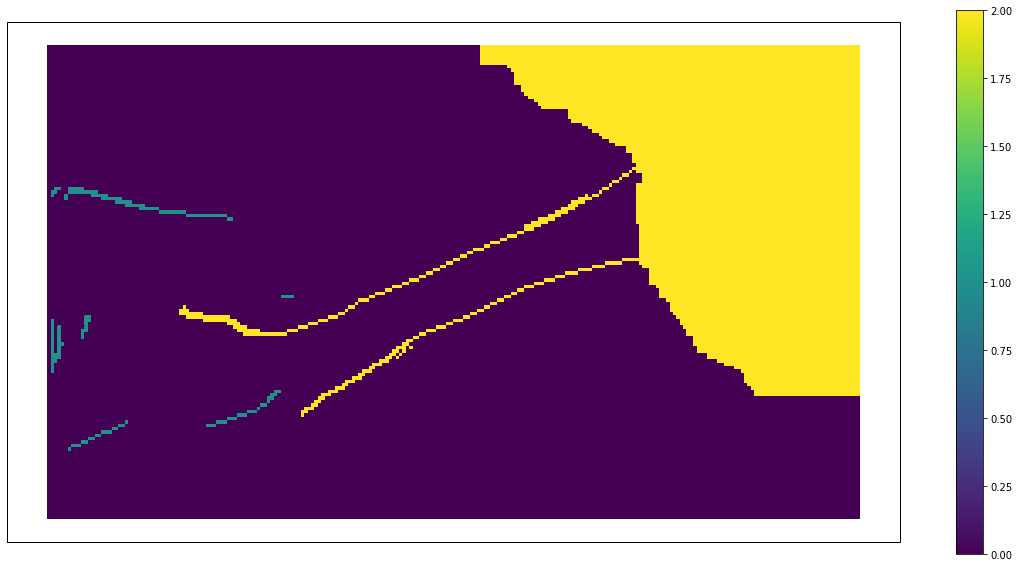

In [93]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
pcm = ax.pcolormesh(
lons, lats, mask_floodfilled[timeind,:,:])
ax.coastlines()
fig.colorbar(pcm)

In [94]:
## suppress unconnected edges

In [95]:
mask_floodfilled[mask_floodfilled<2]=0
mask_floodfilled[mask_floodfilled==2]=1

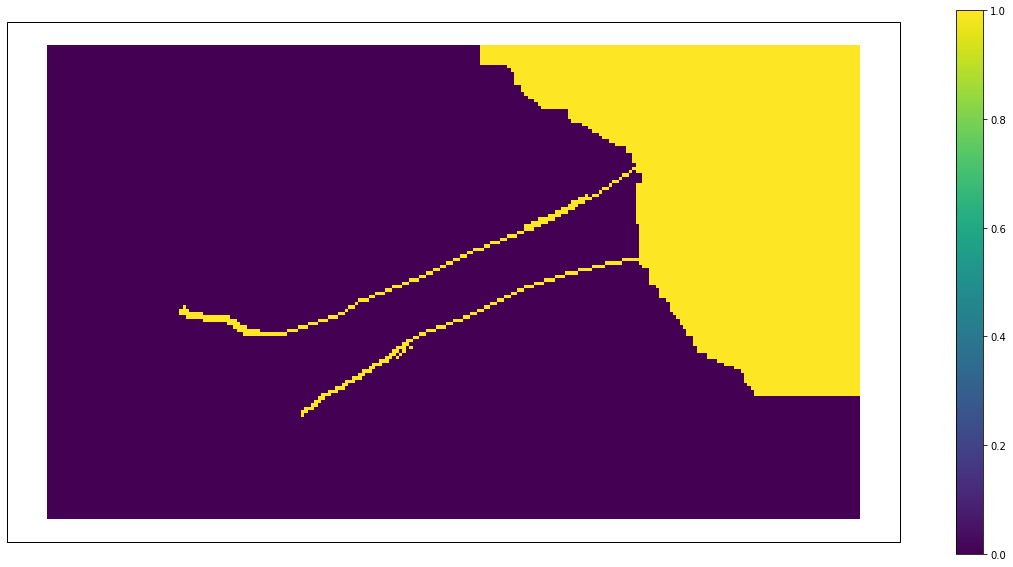

In [96]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
pcm = ax.pcolormesh(
lons, lats, mask_floodfilled[timeind,:,:])
ax.coastlines()
fig.colorbar(pcm)

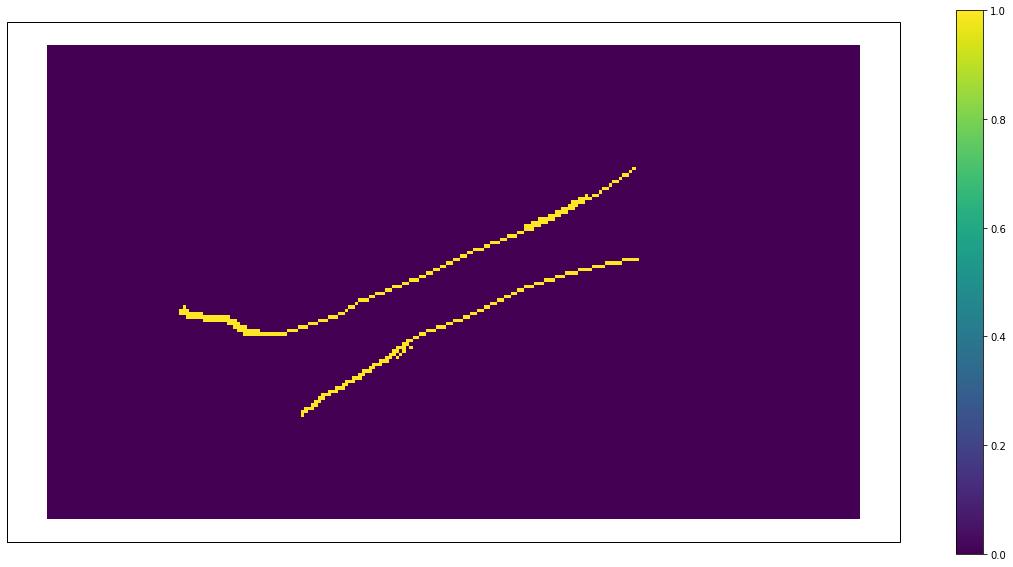

In [97]:
## subtract lsm again
mask_result=mask_floodfilled-lsm

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
pcm = ax.pcolormesh(
lons, lats, mask_result[timeind,:,:])
ax.coastlines()
fig.colorbar(pcm)

In [98]:
del mask_floodfilled

In [99]:
### output of m
outfilename = 'ERA5_qvi_Pacific_hourly_' + "detected_rivers_sigmaS" + str(sigma_d.magnitude) + "_sigmaT" + str(sigma_t.magnitude) + "_percupper" + str(perc_upper) + "_perclower" + str(perc_lower) + '_' + period + ".nc"
dummyfile='dummy_hourly_' + period + '.nc'
!cp $data_folder/$dummyfile $data_folder/$outfilename
write_netcdf_3d(mask_result, data_folder / outfilename)